### **Imports**

In [1]:
import statsmodels.api as sm
from scipy import stats
import scipy.stats as stat
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from pickle import dump, load 
from sklearn.model_selection import train_test_split

In [2]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=True, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default True)
    bins: number of bins for histogram (default None)

    """
    min_val = data[feature].min()
    max_val = data[feature].max()
    mean_val = data[feature].mean()
    med_val = data[feature].median()
    mod_val = data[feature].mode()[0]
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    plt.tight_layout()
    
    plt.show()
    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### **Data reading and descritive study**

This code was created taking the following reference:  

- https://github.com/Gerardo226/LinearRegression-Using-StatsModels/blob/main/Recell.ipynb

See it: 

- https://www.qualtrics.com/support/pt-br/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/?rid=langMatch&prevsite=en&newsite=pt-br&geo=BR&geomatch=

In [3]:
file = 'C:/Users/luissantos/Documents/Statistical_Analysis/data_slopes_dams_claudio_resultados.csv'
data = pd.read_csv(file)
data.columns = ['Model', 'Height','Inclination', 'Cohesion',
                'Friction_angle', 'Specific_weight', 'Safety_factor']
data.drop('Model', axis=1, inplace=True)

# ONLY USING DATA WITH FS < 10!
df = data[data['Safety_factor'] < 10]

In [4]:
#Description of the data in the DataFrame. 
stats = data.describe().T
stats[['mean','50%','min','max', 'std']]

,mean,50%,min,max,std
Height,101.000000,101.000000,2.099000,199.901000,57.186248
Inclination,32.500000,32.500000,5.027500,59.972500,15.885069
Cohesion,150.000000,150.000000,0.150000,299.850000,86.645831
Friction_angle,25.000000,25.000000,0.025000,49.975000,14.440972
Specific_weight,20.000000,20.000000,10.010000,29.990000,5.776389
Safety_factor,3.151795,1.860776,0.041275,50.027778,4.230568


The study proposed here is applied to the saturated scenario considering the following features: 
* Height - meters 
* Inclination - degrees
* Cohesion - kPa
* Friction angle - degrees
* Specific weight - kN/m³
* Safety factor 

The range of FS values is (0.041275 ~ 9.94) which means values outside of the conventional. 
 
* The difference between mean and median (50%) of safety factor may means outliers. 

In [5]:
# Some our columns means are greater then our median presenting a right skewed distribution with can present outliers
col = [a for a in df.select_dtypes(include=[np.number])]
print(f'The percentace of data within 3 standards of')
for a in col:
    print(df[a].mean()+ 2 *df[a].std())
    x = df.loc[(df[a] <= df[a].mean()+ 2 * df[a].std())&
          (df[a]>+ df[a].mean() - 3 * df[a].std())][a].count()/df[a].count()
    
    print(f' {a}: {np.round(x,3)}%')

The percentace of data within 3 standards of
215.65410027211342
 Height: 1.0%
64.02721108830634
 Inclination: 1.0%
319.8873651388865
 Cohesion: 1.0%
53.51920020901267
 Friction_angle: 1.0%
31.659669247553587
 Specific_weight: 1.0%
6.582995847259611
 Safety_factor: 0.934%


In [6]:
data.describe().loc[['min','max', 'mean','50%','std'], :].T

,min,max,mean,50%,std
Height,2.099000,199.901000,101.000000,101.000000,57.186248
Inclination,5.027500,59.972500,32.500000,32.500000,15.885069
Cohesion,0.150000,299.850000,150.000000,150.000000,86.645831
Friction_angle,0.025000,49.975000,25.000000,25.000000,14.440972
Specific_weight,10.010000,29.990000,20.000000,20.000000,5.776389
Safety_factor,0.041275,50.027778,3.151795,1.860776,4.230568


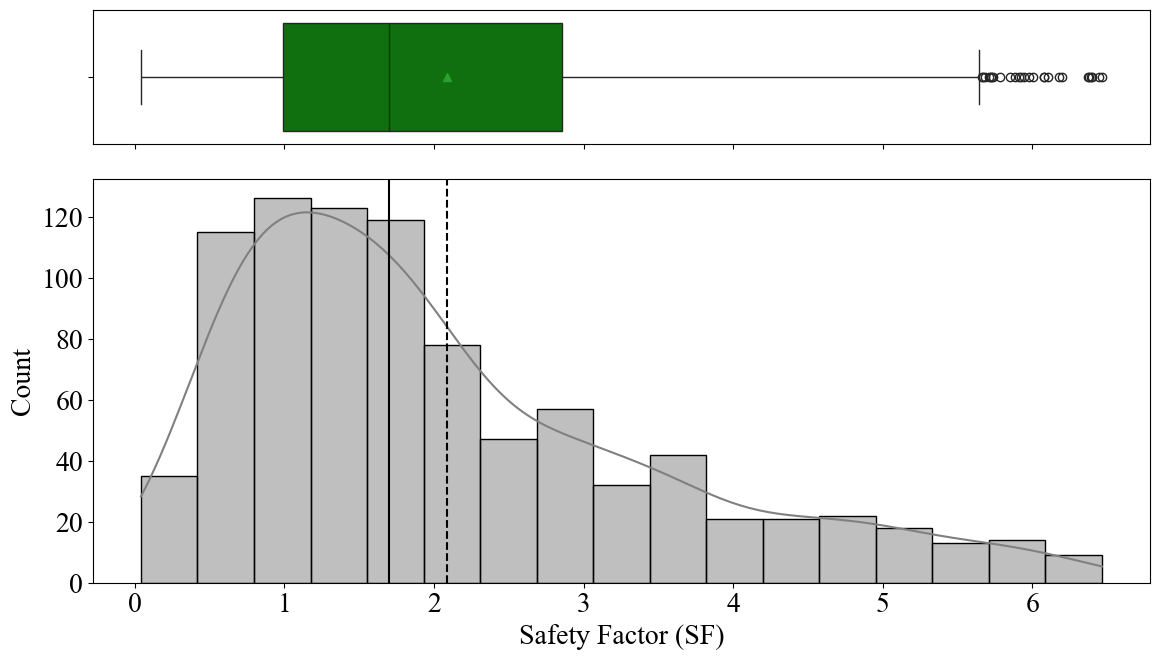

In [10]:
feature = 'Safety_factor'
figsize = (12, 7)
kde = True
bins = None

data = df[df[feature] < 6.53]

min_val = data[feature].min()
max_val = data[feature].max()
mean_val = data[feature].mean()
med_val = data[feature].median()
mod_val = data[feature].mode()[0]

plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Times New Roman'

f2, (ax_box2, ax_hist2) = plt.subplots(
    nrows=2,  # Number of rows of the subplot grid= 2
    sharex=True,  # x-axis will be shared among all subplots
    gridspec_kw={"height_ratios": (0.25, 0.75)},
    figsize=figsize,
)  # creating the 2 subplots
sns.boxplot(
    data=data, x=feature, ax=ax_box2, showmeans=True, color="green",
)  # boxplot will be created and a triangle will indicate the mean value of the column
sns.histplot(
    data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
) if bins else sns.histplot(
    data=data, x=feature, kde=kde, ax=ax_hist2, edgecolor="black", color="gray"
)  # For histogram
ax_hist2.axvline(
    data[feature].mean(), color="k", linestyle="--"
)  # Add mean to the histogram
ax_hist2.axvline(
    data[feature].median(), color="black", linestyle="-"
)  # Add median to the histogram
plt.tight_layout()
ax_hist2.set_xlabel('Safety Factor (SF)')
plt.show()


The majority of the numeric columns are within 3std from the mean. We can remove the data that is not between 3 stds since it will affect our model later on

### **Exploratory data analysis (EBA)**

#### **Init**

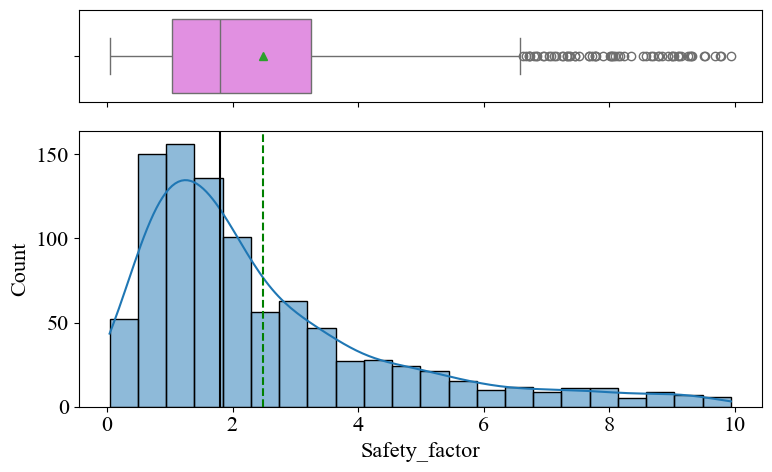

Minimum:0.04
Mean:2.48
Median:1.79
Mode:0.04
Maximum:9.94



In [9]:
histogram_boxplot(df, 'Safety_factor', figsize=(8,5))

**PS.** The results shows the outlines existence!

Inclination       -0.447146
Height            -0.437527
Specific_weight   -0.149285
Cohesion           0.318377
Friction_angle     0.524924
Safety_factor      1.000000
Name: Safety_factor, dtype: float64

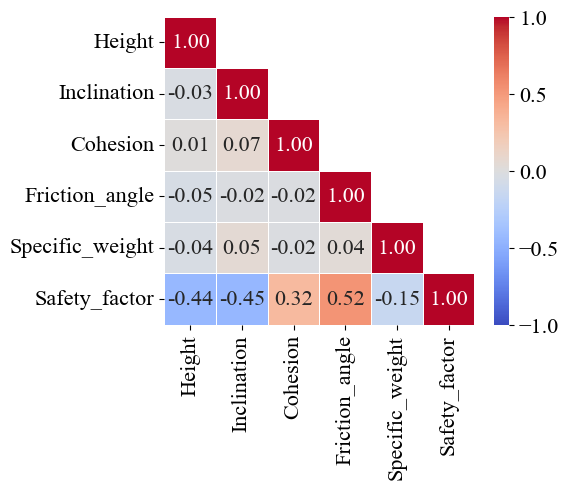

In [10]:
correlation = df.corr(method='spearman')

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False

plt.figure(figsize=(5,4))
plot = sns.heatmap(correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
                   annot = True, fmt=".2f", linewidths=.6)
plt.xticks(rotation = 90)
plot

# correlations to our normalized used price 
correlation['Safety_factor'].sort_values()

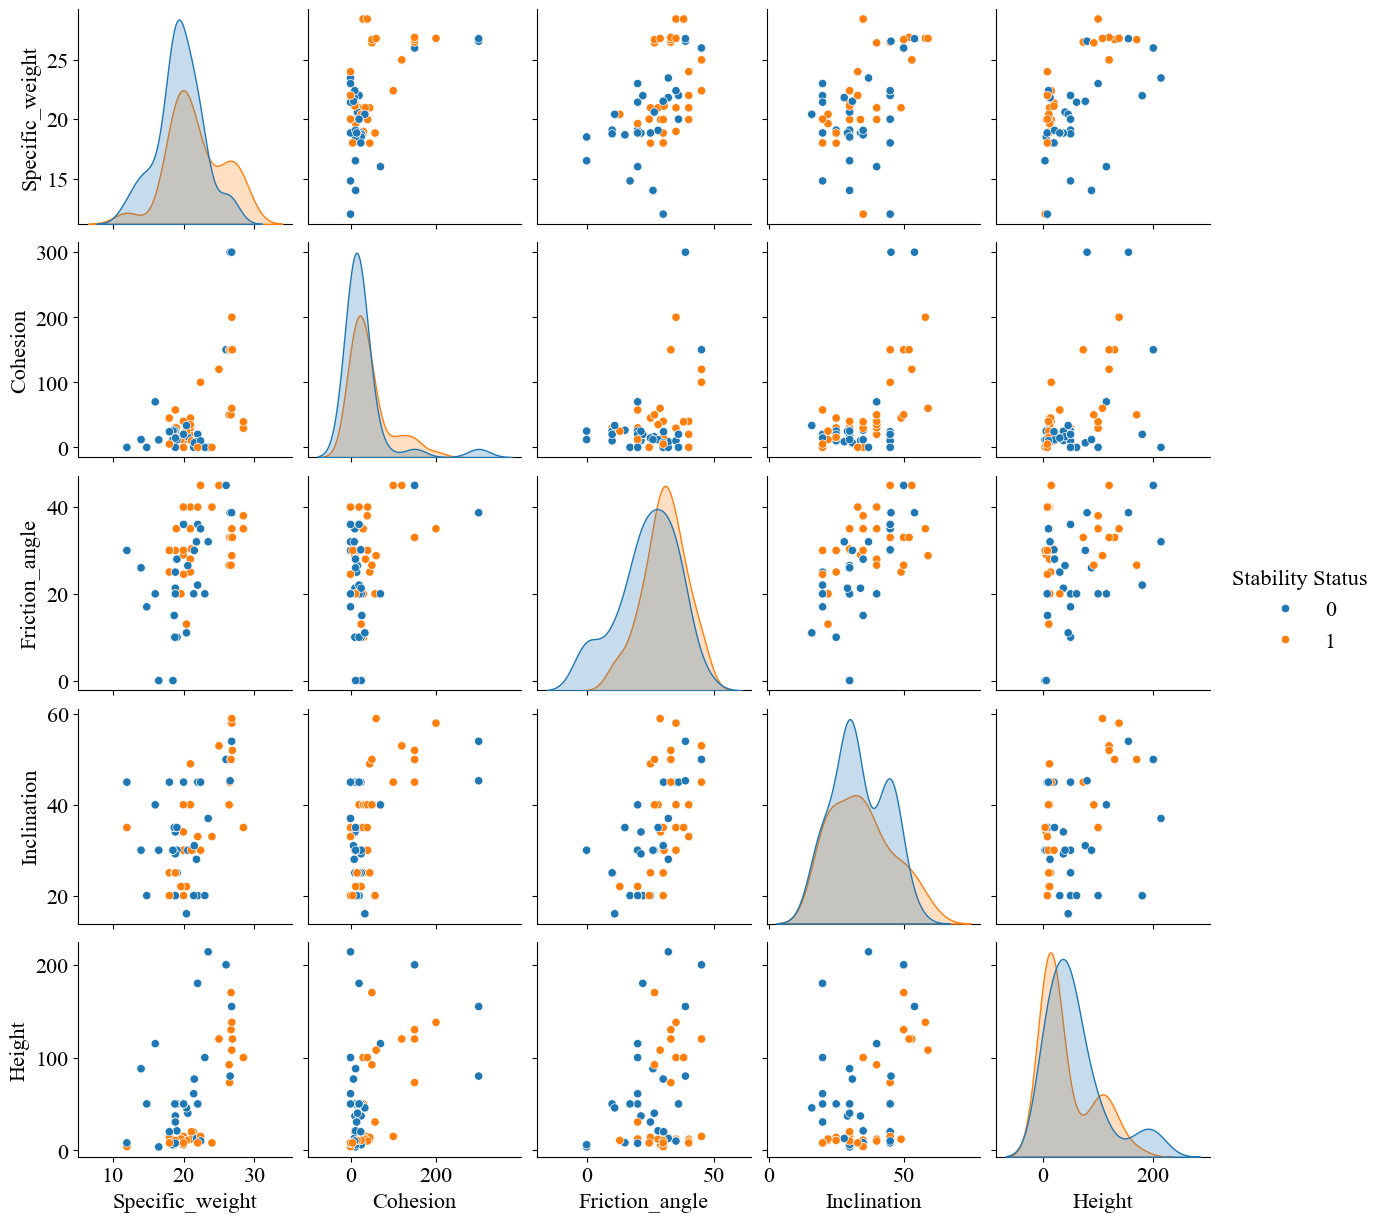

In [20]:
field_data = pd.read_csv('C:\\Users\\luissantos\\Documents\\Statistical_Analysis\\field_data.txt', delimiter='\t')
field_data.drop('Authors ', axis=1, inplace=True)
field_data = field_data[field_data['b (°)'] < 60].drop(labels='ru', axis=1)


init = ['Authors ', 'γ (KN/m3)', ' c (kPa)', 'ϕ (°)', 'b (°)', 'H (m)', 'Stability Status']
field_data.columns = ['Specific_weight', 'Cohesion', 'Friction_angle', 'Inclination','Height', 'Stability Status']
sns.pairplot(data=field_data, kind='scatter', diag_kind='kde', hue='Stability Status')



In [65]:
df1 = df.copy()
df1['Safety_factor_log'] = np.log(df1['Safety_factor'])
correlation = df1.corr('spearman')
correlation['Safety_factor_log']

Height              -0.437527
Inclination         -0.447146
Cohesion             0.318377
Friction_angle       0.524924
Specific_weight     -0.149285
Safety_factor        1.000000
Safety_factor_log    1.000000
Name: Safety_factor_log, dtype: float64

In [ ]:
# # Correlation: Log(FS)
# Inclination       -0.447146
# Height            -0.437527
# Specific_weight   -0.149285
# Cohesion           0.318377
# Friction_angle     0.524924
# Safety_factor      1.000000

# # Correlation: (FS)
# Height            -0.425384
# Inclination       -0.431845
# Cohesion           0.237368
# Friction_angle     0.433504
# Specific_weight   -0.129221
# Safety_factor      1.000000

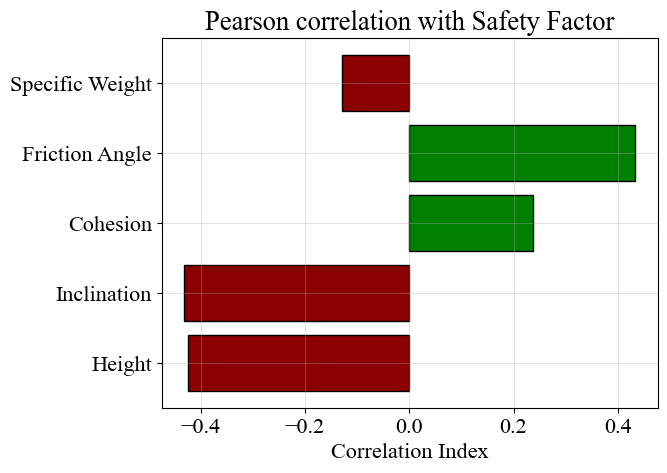

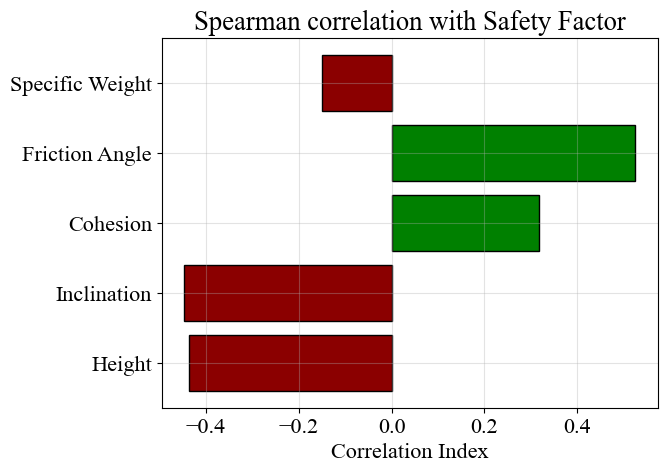

In [23]:
# Make a bar plot of the safety factor correlation index
correlation = df.corr()

plt.figure()
plt.title('Pearson correlation with Safety Factor')
y_index = ['Height', 'Inclination', 'Cohesion', 'Friction Angle', 'Specific Weight']
#  Set color green if positive and red if negative
c = plt.barh(y_index, correlation['Safety_factor'][:-1], 
         color = ['darkred' if x < 0 else 'green' for x in correlation['Safety_factor'][:-1]], 
         edgecolor='black')

plt.xlabel('Correlation Index')
plt.grid(alpha=0.35)

# Make a bar plot of the safety factor correlation index
correlation = df.corr(method='spearman')

plt.figure()
plt.title('Spearman correlation with Safety Factor')
y_index = ['Height', 'Inclination', 'Cohesion', 'Friction Angle', 'Specific Weight']
#  Set color green if positive and red if negative
c = plt.barh(y_index, correlation['Safety_factor'][:-1], 
             color = ['darkred' if x < 0 else 'green' for x in correlation['Safety_factor'][:-1]], 
             edgecolor='black')

plt.xlabel('Correlation Index')
plt.grid(alpha=0.35)

**A priori:**
* Não é possível observar padrões/correlações muito altas e claras entre as variáveis
de entrada e o fator de segurança.   

* É possível observar um desbalanceamento na distribuição dos valores dos fatores de
segurança. 

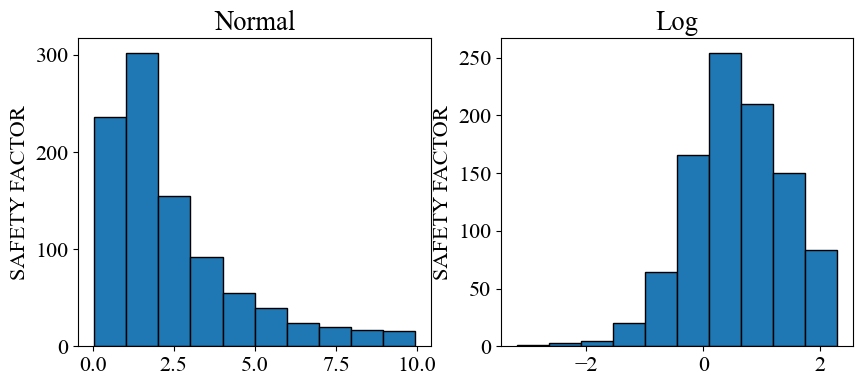

In [24]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(10)
ax[0].hist(data=df, x='Safety_factor', edgecolor = 'k')
ax[1].hist(data=np.log(df), x='Safety_factor', edgecolor = 'k')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[0].set_ylabel('SAFETY FACTOR')
ax[1].set_ylabel('SAFETY FACTOR')
ax[1].set_title('Log')
ax[0].set_title('Normal')
plt.show()

**Safety Factor distribution**

* We can see a log-normal distribution when using normal data

* We can see a normal distribution when using log data


In [25]:
df['lg_SF'] = np.log(df['Safety_factor'])
df

,Height,Inclination,Cohesion,Friction_angle,Specific_weight,Safety_factor,lg_SF
0,44.273,23.6725,285.45,44.375,19.23,5.739904,1.747443
1,23.681,40.9425,234.15,23.425,15.55,5.381333,1.682936
2,74.765,17.9525,151.05,43.825,17.01,4.720918,1.552003
3,48.035,24.4975,52.65,19.475,23.91,1.386943,0.327102
4,197.525,27.5775,205.65,4.925,11.45,0.903322,-0.101676
...,...,...,...,...,...,...,...
995,180.299,56.7275,163.95,23.125,25.81,0.700102,-0.356529
996,51.797,43.2525,180.15,0.725,18.63,1.497044,0.403493
997,46.451,34.3425,218.55,19.325,27.53,2.009205,0.697739
998,28.235,9.2075,279.15,16.525,17.61,8.227008,2.107422


<Figure size 640x480 with 0 Axes>

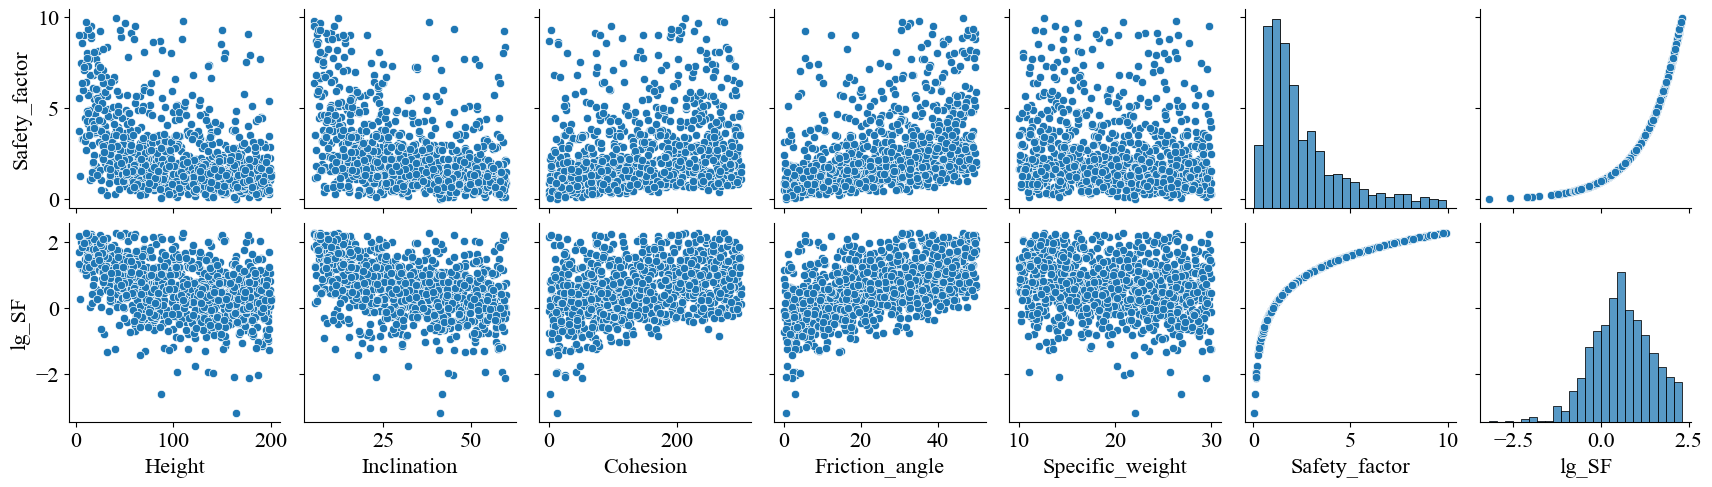

In [26]:
plt.figure()
_ = sns.pairplot(data=df, diag_kind="hist", y_vars=['Safety_factor', 'lg_SF'])

Inclination       -0.431845
Height            -0.425384
Specific_weight   -0.129221
Cohesion           0.237368
Friction_angle     0.433504
lg_SF              0.890443
Safety_factor      1.000000
Name: Safety_factor, dtype: float64

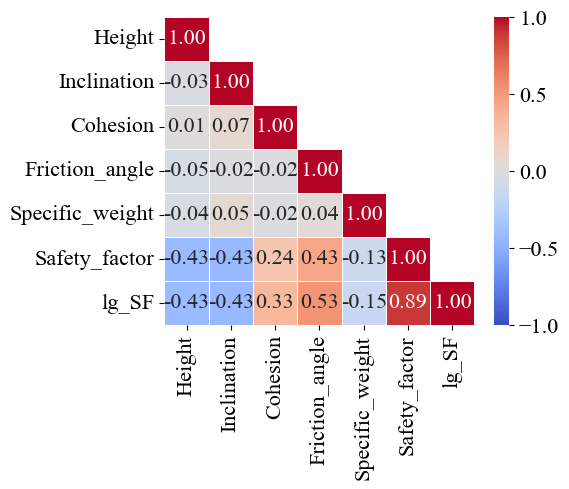

In [27]:
correlation = df.corr(method='pearson')

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

# Want diagonal elements as well
mask[np.diag_indices_from(mask)] = False

plt.figure(figsize=(5,4))
plot = sns.heatmap(correlation, mask=mask, vmin=-1, cmap= 'coolwarm',
                   annot = True, fmt=".2f", linewidths=.6)
plt.xticks(rotation = 90)
plot

# correlations to our normalized used price 
correlation['Safety_factor'].sort_values()

#### **Data Preprocessing**

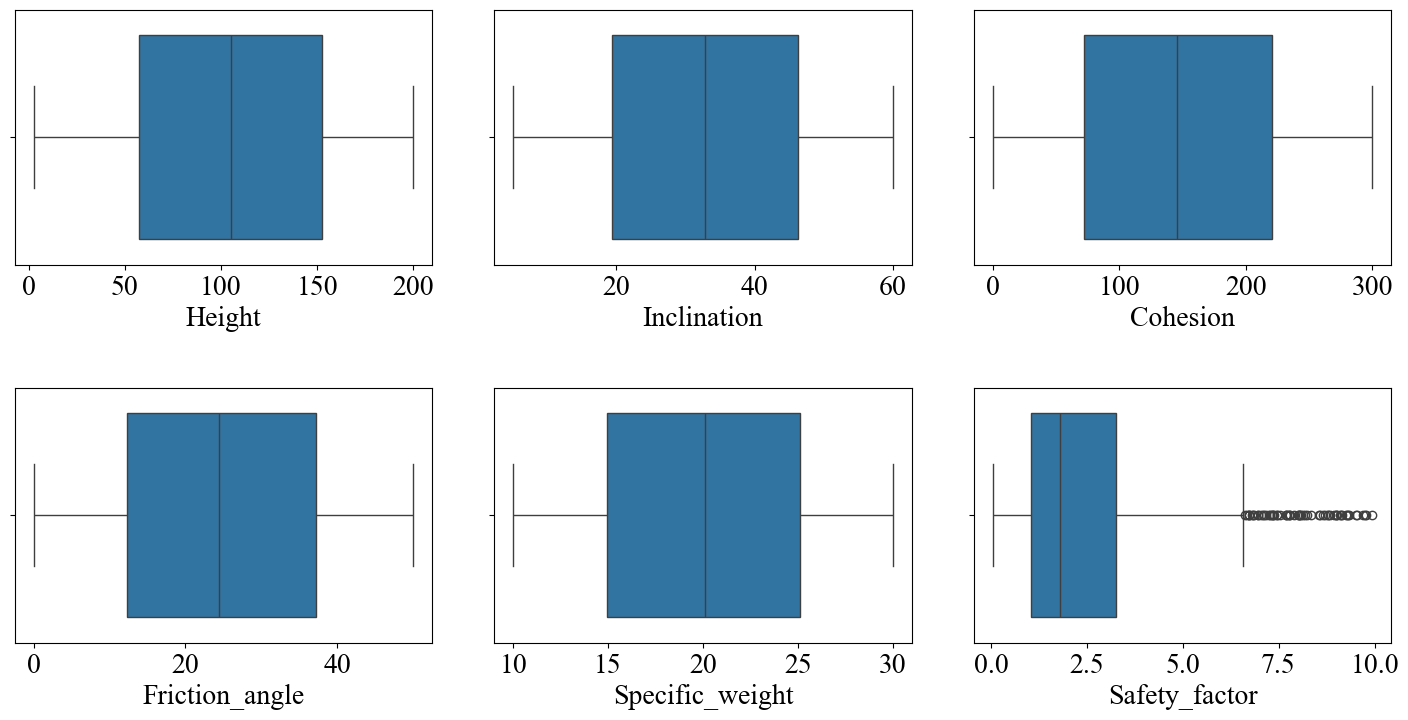

In [12]:
# outlier detection using boxplot
num_cols = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 15))

for i, variable in enumerate(num_cols):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(data=df, x=variable)
    plt.tight_layout(pad=2)

plt.show()

We can see outlines in the obtained values of safety factor 

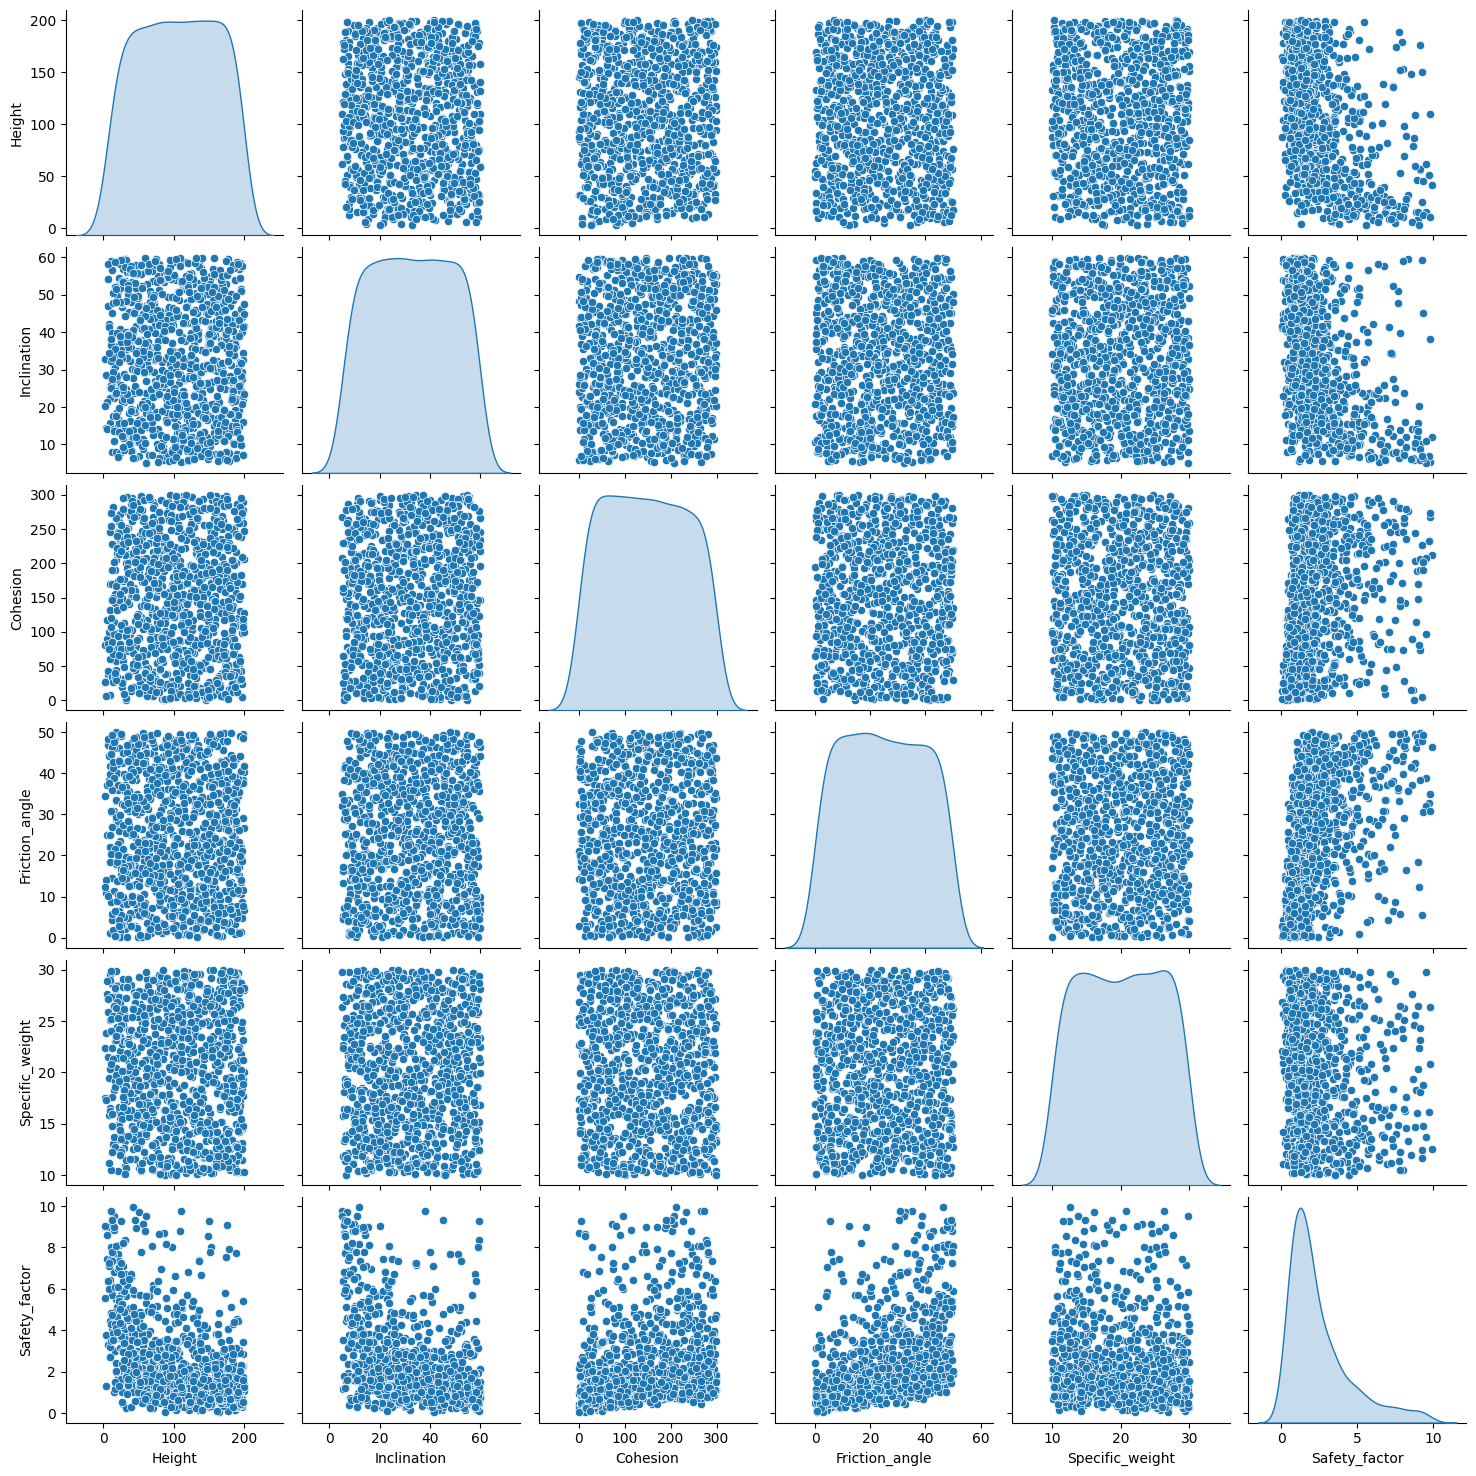

In [34]:
sns.pairplot(data = df, diag_kind = 'kde');

**Conclusions:**
We dont see any strong linear relationship in our data



### **Model Building - Linear Regression**


In [18]:
file = 'C:/Users/luissantos/Documents/Statistical_Analysis/data_slopes_dams_claudio_resultados.csv'
data = pd.read_csv(file)
data.columns = ['Model', 'Height','Inclination', 'Cohesion',
                'Friction_angle', 'Specific_weight', 'Safety_factor']
data.drop('Model', axis=1, inplace=True)

# ONLY USING DATA WITH FS < 10!
df = data[data['Safety_factor'] < 2*data['Safety_factor'].std()]

In [19]:
# splitting the data in 70:30 ratio for train to test data
X = df.drop(["Safety_factor"], axis=1)
y = df["Safety_factor"]

x_lin_fs = df.drop(["Safety_factor"], axis=1)
x_lin_fs = sm.add_constant(x_lin_fs)
y_lin_fs = y
model_lin_fs = sm.OLS(y_lin_fs, x_lin_fs).fit()

y_lin_log_fs = np.log(y)
model_lin_log_fs = sm.OLS(y_lin_log_fs, x_lin_fs).fit()

print(model_lin_log_fs.summary())
print(model_lin_fs.summary())

                            OLS Regression Results                            
Dep. Variable:          Safety_factor   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     702.4
Date:                Tue, 06 Aug 2024   Prob (F-statistic):          4.19e-312
Time:                        14:03:30   Log-Likelihood:                -384.34
No. Observations:                 932   AIC:                             780.7
Df Residuals:                     926   BIC:                             809.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1744      0.062     

In [20]:
# plot correct coef, sup e inf
df_ic = model_lin_fs.conf_int()
df_ic['params'] = model_lin_fs.params
df_ic.columns = ['inferior', 'superior', 'coef']
df_ic = df_ic.reset_index()

In [22]:
# splitting the data in 70:30 ratio for train to test data
df = data[data['Safety_factor'] < 2*data['Safety_factor'].std()]
X = df.drop(["Safety_factor"], axis=1)
y = df["Safety_factor"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=1)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

print("Number of rows in train data =", x_train.shape[0])
print("Number of rows in test data =", x_test.shape[0])

# Make OLS with a fully-quadractic model 
#Add combined terms to the model
default_columns = x_train.columns
control_list = []
for i in default_columns:
    for j in default_columns:
        control_list.append([i, j])
        if [j, i] not in control_list:
            print(i,'-',j)
            x_train[i+'*'+j] = x_train[i]*x_train[j]
            x_test[i+'*'+j] = x_test[i]*x_test[j]
# Add quadratic terms to the model
for i in default_columns:
    print(i,'-',i)
    x_train[i+'*'+i] = x_train[i]**2
    x_test[i+'*'+i] = x_test[i]**2

# let's add the intercept to data
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# fit the model
model_quad_fs = sm.OLS(y_train, x_train).fit()
model_quad_log_fs = sm.OLS(y_train_log, x_train).fit()

print(model_quad_fs.summary())
print(model_quad_log_fs.summary())

Number of rows in train data = 922
Number of rows in test data = 10
Height - Inclination
Height - Cohesion
Height - Friction_angle
Height - Specific_weight
Inclination - Cohesion
Inclination - Friction_angle
Inclination - Specific_weight
Cohesion - Friction_angle
Cohesion - Specific_weight
Friction_angle - Specific_weight
Height - Height
Inclination - Inclination
Cohesion - Cohesion
Friction_angle - Friction_angle
Specific_weight - Specific_weight
                            OLS Regression Results                            
Dep. Variable:          Safety_factor   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     331.2
Date:                Tue, 06 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:03:45   Log-Likelihood:                -858.16
No. Observations:                 922   AIC:                             1

In [23]:
def plot_predictions(model, x, y, log = False):

    predicted = model.predict(x) 
    
    predicted = np.exp(predicted) if log else predicted
    y = np.exp(y) if log else y

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots()
    ax.set_title(f'Linear regression training - R² = {r2_score(y, predicted).__round__(3)}')
    ax.scatter(y, predicted, edgecolor='k')
    ax.plot([0,10], [0,10], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.grid(alpha = .5)
    plt.show()

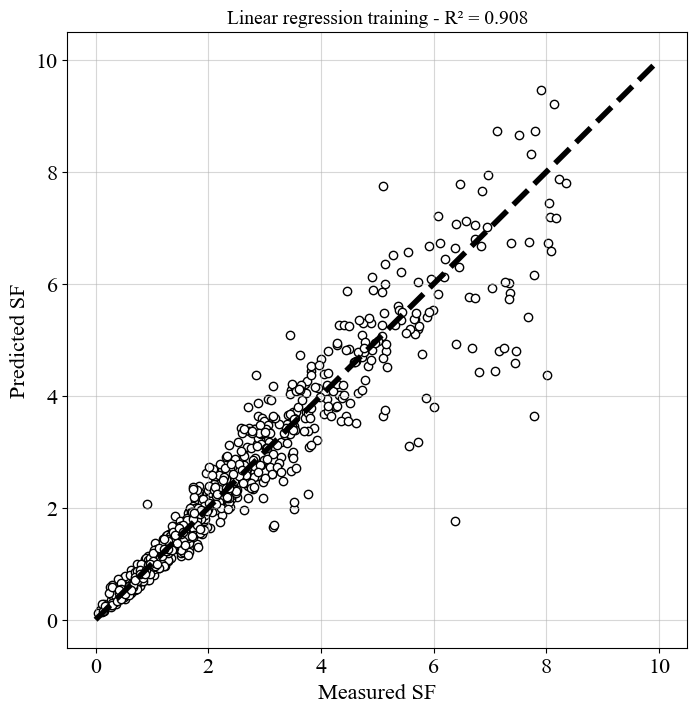

In [30]:
model, x, y = model_quad_log_fs, x_train, y_train_log 

predicted = model.predict(x) 
log = True

predicted = np.exp(predicted) if log else predicted
y = np.exp(y) if log else y

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title(f'Linear regression training - R² = {r2_score(y, predicted).__round__(3)}', size = 14)
ax.scatter(y, predicted, edgecolor='k', color = 'w')
ax.plot([0,10], [0,10], 'k--', lw=4)
ax.set_xlabel('Measured SF')
ax.set_ylabel('Predicted SF')
ax.grid(alpha = .5)
plt.show()

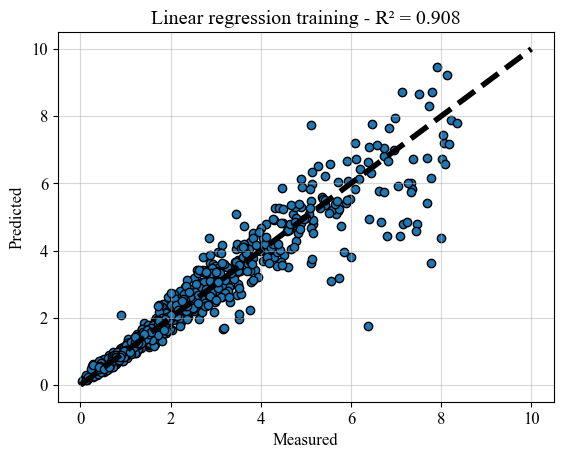

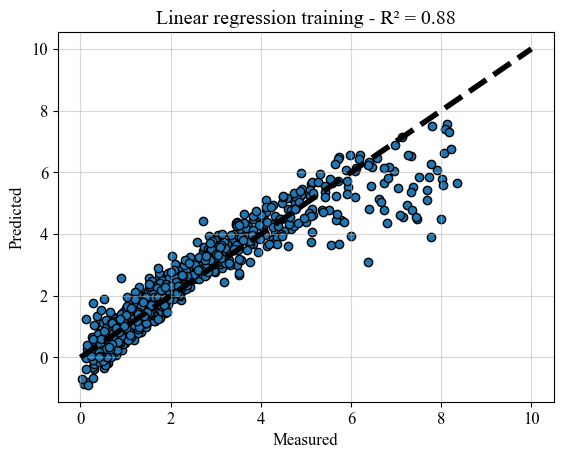

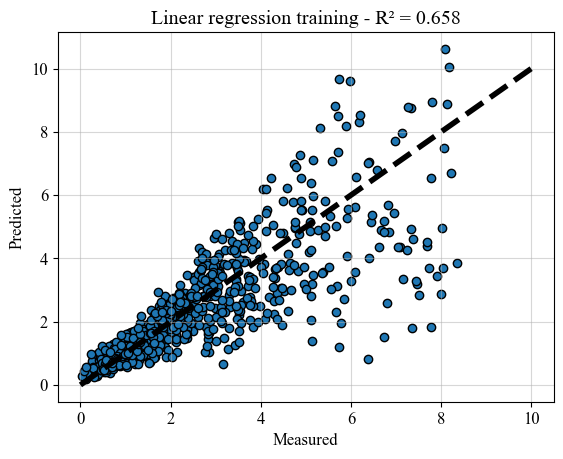

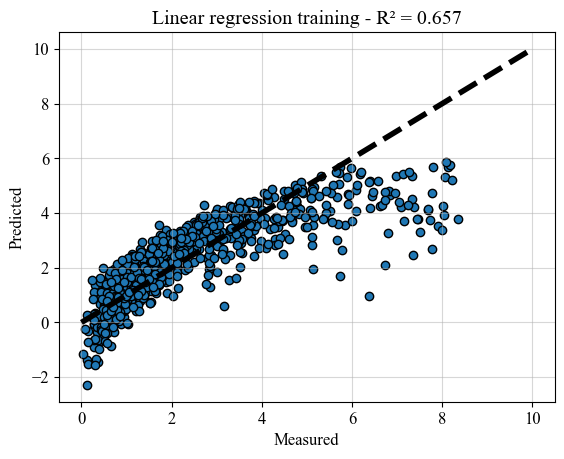

In [24]:
plot_predictions(model_quad_log_fs, x_train, y_train_log, log = True)
plot_predictions(model_quad_fs, x_train, y_train, log = False)
plot_predictions(model_lin_log_fs, x_lin_fs, y_lin_log_fs, log = True)
plot_predictions(model_lin_fs, x_lin_fs, y_lin_fs, log = False)

Text(0, 0.5, 'MAPE(%)')

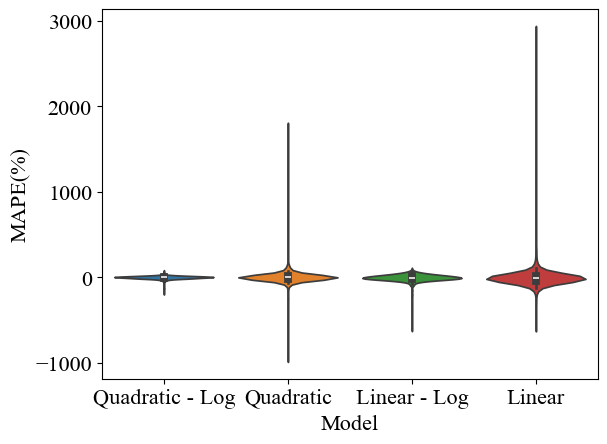

In [31]:
def get_residuals(model, x, y, log = False):
    predicted = model.predict(x)
    predicted = np.exp(predicted) if log else predicted
    y = np.exp(y) if log else y
    y = list(y)
    residuals = 100*(y - predicted)/y
    df = pd.DataFrame([y, predicted, residuals]).T
    df.columns = ['y', 'predicted', 'residuals']
    return df

l1 = get_residuals(model_quad_log_fs, x_train, y_train_log, log = True)
l2 = get_residuals(model_quad_fs, x_train, y_train, log = False)
l3 = get_residuals(model_lin_log_fs, x_lin_fs, y_lin_log_fs, log = True)
l4 = get_residuals(model_lin_fs, x_lin_fs, y_lin_fs, log = False)

l1['model'] = 'Quadratic - Log'
l2['model'] = 'Quadratic'
l3['model'] = 'Linear - Log'
l4['model'] = 'Linear'

df = pd.concat([l1, l2, l3, l4])
sns.violinplot(df, x = 'model', y = 'residuals', hue='model')
plt.xlabel('Model')
plt.ylabel('MAPE(%)')

#### **Model Performance Check**


In [32]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100

# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target, log = False):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    pred = np.exp(pred) if log else pred
    target = np.exp(target) if log else target

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [33]:
print('linear - FS')
print(model_performance_regression(model_lin_fs, x_lin_fs, y_lin_fs, log = False))
print('linear - log(FS)')
print(model_performance_regression(model_lin_log_fs, x_lin_fs, y_lin_log_fs, log = True))
print('quadratic - FS')
print(model_performance_regression(model_quad_fs, x_train, y_train, log = False))
print('quadratic - log(FS)')
print(model_performance_regression(model_quad_log_fs, x_train, y_train_log, log = True))

linear - FS
       RMSE       MAE  R-squared  Adj. R-squared       MAPE
0  1.035808  0.747075   0.656873        0.654647  54.199075
linear - log(FS)
       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  1.033428  0.612886   0.658448        0.656232  27.17555
quadratic - FS
       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.613745  0.425964   0.880277        0.877483  33.55752
quadratic - log(FS)
       RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.536581  0.289999   0.908489        0.906354  12.51668


**Observations: (CORRIGIR)**  

 * The training and test R² are 0.72 and 0.69, so the model is not underfitting

 * The train and test RMSE and MAE are closed, so the model is not overfitting either

 * MAE suggests that the model can predict anime ratings within a mean error of 0.348 on the test data

#### **Checking Linear Regression Assumptions**


We will be checking the following Linear Regression assumptions:  

* No Multicollinearity

* Linearity of variables

* Independence of error terms

* Normality of error terms

* No Heteroscedasticity

In [34]:
# we will define a function to check VIF
def checking_vif(predictors):
    vif = pd.DataFrame()
    vif["feature"] = predictors.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        round(variance_inflation_factor(predictors.values, i), 3) for i in range(len(predictors.columns))
    ]
    return vif

In [35]:
checking_vif(x_train).sort_values(by = 'VIF',
                                  ascending = False)

,feature,VIF
0,const,514.288
5,Specific_weight,79.610
20,Specific_weight*Specific_weight,62.927
2,Inclination,46.763
1,Height,43.158
3,Cohesion,41.377
4,Friction_angle,37.524
17,Inclination*Inclination,24.162
12,Inclination*Specific_weight,19.698
16,Height*Height,18.907


**PS.**
* Se o Variable Independence Factor (VIF) is higher than 5, there is multicolinearity 

#### **Removing Multicollinearity - that isn't our case**

To remove multicollinearity  

1. Drop every column one by one that has a VIF score greater than 5.
2. Look at the adjusted R-squared and RMSE of all these models.
3. Drop the variable that makes the least change in adjusted R-squared.
4. Check the VIF scores again.
5. Continue till you get all VIF scores under 5.  


Let's define a function that will help us do this.

In [36]:
def treating_multicollinearity(predictors, target, high_vif_columns):
    """
    Checking the effect of dropping the columns showing high multicollinearity
    on model performance (adj. R-squared and RMSE)

    predictors: independent variables
    target: dependent variable
    high_vif_columns: columns having high VIF
    """
    # empty lists to store adj. R-squared and RMSE values
    adj_r2 = []
    rmse = []

    # build ols models by dropping one of the high VIF columns at a time
    # store the adjusted R-squared and RMSE in the lists defined previously
    for cols in high_vif_columns:
        # defining the new train set
        train = predictors.loc[:, ~predictors.columns.str.startswith(cols)]

        # create the model
        olsmodel = sm.OLS(target, train).fit()

        # adding adj. R-squared and RMSE to the lists
        adj_r2.append(olsmodel.rsquared_adj)
        rmse.append(np.sqrt(olsmodel.mse_resid))

    # creating a dataframe for the results
    temp = pd.DataFrame(
        {
            "col": high_vif_columns,
            "Adj. R-squared after_dropping col": adj_r2,
            "RMSE after dropping col": rmse,
        }
    ).sort_values(by="Adj. R-squared after_dropping col", ascending=False)
    temp.reset_index(drop=True, inplace=True)

    return temp

In [37]:
cols = x_train.columns
treating_multicollinearity(x_train, y_train, cols)

,col,Adj. R-squared after_dropping col,RMSE after dropping col
0,const,0.945427,0.680368
1,Cohesion*Friction_angle,0.877754,0.620515
2,Height*Friction_angle,0.877752,0.620520
3,Inclination*Cohesion,0.877737,0.620558
4,Friction_angle*Specific_weight,0.877710,0.620626
5,Inclination*Specific_weight,0.877687,0.620684
6,Height*Inclination,0.877670,0.620726
7,Cohesion*Cohesion,0.877453,0.621277
8,Friction_angle*Friction_angle,0.877385,0.621449
9,Cohesion*Specific_weight,0.875151,0.627085


In [38]:
col_to_drop = ['const']
x_train2 = x_train.loc[:, ~x_train.columns.str.startswith(col_to_drop)]
x_test2 = x_test.loc[:, ~x_test.columns.str.startswith(col_to_drop)]

# Check VIF now
vif = checking_vif(x_train2)
print("VIF after dropping ", col_to_drop)
vif.sort_values(by =  'VIF', ascending = False)

TypeError: expected a string or tuple, not list

**Conclusions:**
* After removing specific weight, the model's performance was improved!

#### **Dropping high p-value variables**

* We will drop the predictor variables having a **p-value greater than 0.05** as they do not significantly impact the target variable.
* But sometimes p-values change after dropping a variable. So, we'll not drop all variables at once.
* Instead, we will do the following:  

    1. Build a model, check the p-values of the variables, and drop the column with the highest p-value.
    2. Create a new model without the dropped feature, check the p-values of the variables,  
    and drop the column with the highest p-value.
    3. Repeat the above two steps till there are no columns with p-value > 0.05.

In [39]:
def recursive_feature_elimination(x_train, y_train, threshold=0.05):
    """
    Performs recursive feature elimination using OLS regression based on a p-value threshold.

    Args:
    - x_train: Independent variables in the training set
    - y_train: Dependent variable in the training set
    - threshold: p-value threshold for feature elimination (default is 1)

    Returns:
    - selected_features: List of selected features after recursive feature elimination.
    """

    # initial list of columns
    cols = x_train.columns.tolist()

    # setting an initial max p-value
    max_p_value = 1

    while len(cols) > 0:
        # defining the train set
        x_train_aux = x_train[cols]

        # fitting the model
        model = sm.OLS(y_train, x_train_aux).fit()

        # getting the p-values and the maximum p-value
        p_values = model.pvalues
        max_p_value = max(p_values)

        # name of the variable with maximum p-value
        feature_with_p_max = p_values.idxmax()

        if max_p_value >= threshold:
            cols.remove(feature_with_p_max)
        else:
            break

    selected_features = cols
    print(selected_features)
    
    return selected_features

print('Linear - FS')
selected_features = recursive_feature_elimination(x_lin_fs, y_lin_log_fs, threshold=0.05)
print('Linear - Lg(FS)')
selected_features = recursive_feature_elimination(x_lin_fs, y_lin_fs, threshold=0.05)
print('Quadratic - FS')
selected_features = recursive_feature_elimination(x_train, y_train, threshold=0.05)
print('Quadratic - Lg(FS)')
selected_features = recursive_feature_elimination(x_train, y_train, threshold=0.05)


Linear - FS
['const', 'Height', 'Inclination', 'Cohesion', 'Friction_angle', 'Specific_weight']
Linear - Lg(FS)
['const', 'Height', 'Inclination', 'Cohesion', 'Friction_angle', 'Specific_weight']
Quadratic - FS
['const', 'Height', 'Inclination', 'Cohesion', 'Friction_angle', 'Specific_weight', 'Height*Cohesion', 'Height*Specific_weight', 'Inclination*Friction_angle', 'Cohesion*Specific_weight', 'Height*Height', 'Inclination*Inclination', 'Specific_weight*Specific_weight']
Quadratic - Lg(FS)
['const', 'Height', 'Inclination', 'Cohesion', 'Friction_angle', 'Specific_weight', 'Height*Cohesion', 'Height*Specific_weight', 'Inclination*Friction_angle', 'Cohesion*Specific_weight', 'Height*Height', 'Inclination*Inclination', 'Specific_weight*Specific_weight']


**Conclusões:**

Dessa forma, considerando a hipotese do p-value, o peso específico saiu também e todas as demais ficaram por ter p-value inferior a 1

**Observations**

* Dropping the high p-value predictor variables has not adversely affected the model performance.   

* This shows that these variables do not significantly impact the target variable

#### **Test for linearity and independence**

* We will test for linearity and independence by making a plot of fitted values vs residuals and checking for patterns.

* If there is no pattern, then we say the model is linear and residuals are independent.

* Otherwise, the model is showing signs of non-linearity and residuals are not independent.

In [40]:
# let us create a dataframe with actual, fitted and residual values
df_pred = pd.DataFrame()

df_pred["Actual Values"] = y_lin_log_fs  # actual values
df_pred["Fitted Values"] = model_quad_log_fs.fittedvalues  # predicted values
df_pred["Residuals"] = np.exp(df_pred["Actual Values"]) - np.exp(df_pred["Fitted Values"])  # residuals

df_pred.head()

,Actual Values,Fitted Values,Residuals
0,1.747443,1.656127,0.500921
1,1.682936,1.709596,-0.145396
2,1.552003,1.625475,-0.359912
3,0.327102,0.370575,-0.061624
4,-0.101676,-0.023420,-0.073530


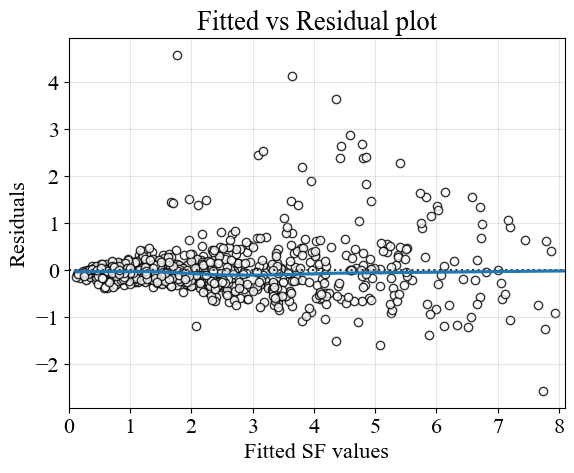

In [64]:
# let's plot the fitted values vs residuals
def plot_fit_vs_residuals(fitted_values: list, residuals:list):
    """
    Function to plot the fitted values vs residuals
    Args:
        fitted_values: list of fitted values
        residuals: list of residuals
    Returns:
        fig: plot of fitted values vs residuals
    """
    if len(fitted_values) != len(residuals):
        raise ValueError("fitted_values and residuals should be of same length")
    
    df_pred = pd.DataFrame()
    df_pred["Fitted Values"] = fitted_values
    df_pred["Residuals"] = residuals
    
    # fig = plt.figure(figsize=(8, 5))
    sns.residplot(data=df_pred,
                  x="Fitted Values", y="Residuals",
                  scatter_kws={'color':"w", 'edgecolor':'k'}, lowess=True)

    plt.xlabel("Fitted SF values")
    plt.ylabel("Residuals")
    plt.title("Fitted vs Residual plot")
    # plt.show()
    # return fig

# let us create a dataframe with actual, fitted and residual values
df_pred = pd.DataFrame()
df_pred["Actual Values"] = y_train_log  # actual values
df_pred["Fitted Values"] = model_quad_log_fs.predict(x_train)  # predicted values
df_pred["Residuals"] = np.exp(df_pred["Actual Values"]) - np.exp(df_pred["Fitted Values"])  # residuals

plt.figure()
plot_fit_vs_residuals(np.exp(df_pred["Fitted Values"]), df_pred["Residuals"])
plt.xticks(range(0,9,1))
plt.xlim(0,8.1)
plt.grid(alpha = 0.33)

**Observations**

* We can see the residuals of the data lower closed to the critical region,
with mean close to zero. 

* The residuals average (norm) increases as the SF increases - consequence of unballanced data. 
    * High residuals far SF=1 are not a problem!

#### **Test for normality**

* We will test for normality by checking the distribution of residuals, by checking the Q-Q plot of residuals, and by using the Shapiro-Wilk test.  
* If the residuals follow a normal distribution, they will make a straight line plot, otherwise not.  
* If the p-value of the Shapiro-Wilk test is greater than 0.05, we can say the residuals are normally distributed.  

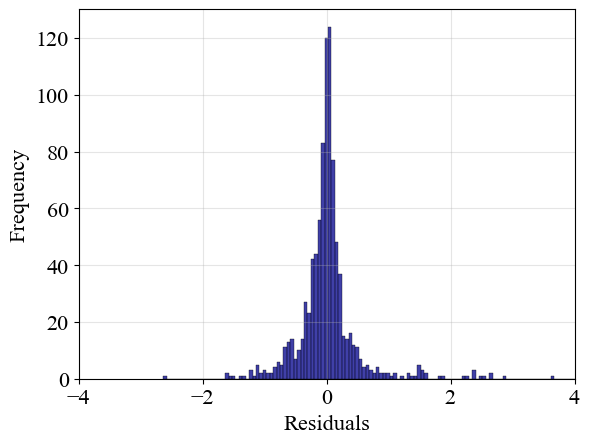

In [73]:
plt.figure()
plt.grid(alpha = 0.33)
sns.histplot(data=df_pred, x="Residuals", kde=False, color='darkblue', edgecolor='black')
plt.ylabel('Frequency')
plt.xlim(-4,4)
plt.show()

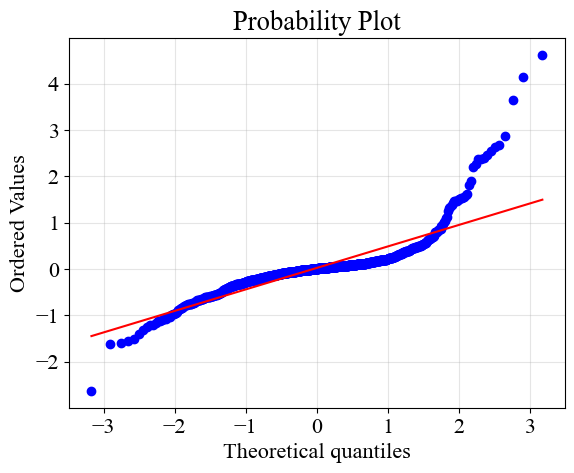

In [78]:
stat.probplot(df_pred["Residuals"], dist="norm", plot=plt)
plt.grid(alpha = 0.33)

In [79]:
stat.shapiro(df_pred["Residuals"]).pvalue

3.0412176029526163e-35

**Observations**

* The histogram of residuals almost has a bell shape structure
* The residuals almost follow a straight line.
* Shapiro results says the distribution is nonnormal but from our previous we can see that is

#### **TEST FOR HOMOSCEDASTICITY**

* We will test for homoscedasticity by using the goldfeldquandt test.
* If we get a p-value greater than 0.05, we can say that the residuals are homoscedastic. Otherwise, they are heteroscedastic.


In [80]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_pred["Residuals"],  x_train)
lzip(name, test)

[('F statistic', 0.9618242690641013), ('p-value', 0.6583589562860419)]

**Observations**

* Since p-value > 0.05, the residuals are homoscedastic.
* So, the assumption is satisfied.  

**All the assumptions of linear regression are satisfied. Let's rebuild our final model, check its performance, and draw inferences from it**

**Homoscedasticidade:**

* Definição: Refere-se à situação em que a variabilidade dos erros (ou resíduos) em um modelo estatístico é constante em todos os níveis da variável independente. Em outras palavras, a dispersão dos erros é uniforme ao longo de toda a gama dos valores da variável explicativa.
* Gráfico Esperado: Ao visualizar os resíduos em relação à variável independente, você esperaria ver uma faixa constante e horizontal, indicando que a variabilidade dos erros não está mudando com a variável explicativa.  

**Heteroscedasticidade:**

Definição:  
* Refere-se à situação em que a variabilidade dos erros não é constante em todos os níveis da variável independente. Isso significa que a dispersão dos erros varia à medida que a variável independente aumenta ou diminui.
* Gráfico Esperado: Ao visualizar os resíduos em relação à variável independente, você observaria uma faixa que se alarga ou contrai, indicando que a variabilidade dos erros muda com a variável explicativa.

A homoscedasticidade é uma suposição importante em muitos modelos estatísticos, incluindo modelos de regressão linear. **Quando essa suposição é violada (ou seja, quando há heteroscedasticidade)**, pode impactar a precisão das estimativas e a validade das inferências estatísticas feitas a partir do modelo.

Em resumo, a homoscedasticidade significa que a variabilidade dos erros é constante, enquanto a heteroscedasticidade significa que a variabilidade dos erros varia.

### ***EVAL under field data***

#### **Final Model and new tests**

##### **Evaluation under de Field data**

In [91]:
from sklearn.metrics import confusion_matrix, classification_report
field_data = pd.read_csv('C:\\Users\\luissantos\\Documents\\Statistical_Analysis\\field_data.txt', delimiter='\t')
field_data.drop('Authors ', axis=1, inplace=True)
field_data = field_data[field_data['b (°)'] < 60].drop(labels='ru', axis=1)


init = ['Authors ', 'γ (KN/m3)', ' c (kPa)', 'ϕ (°)', 'b (°)', 'H (m)', 'Stability Status']
field_data.columns = ['Specific_weight', 'Cohesion', 'Friction_angle', 'Inclination','Height', 'Stability Status']
# sns.pairplot(data=field_data, kind='scatter', diag_kind='kde', hue='Stability Status')

x_field_data = field_data[X.columns]
x_field_data = sm.add_constant(x_field_data)
lin_pred_fs = model_lin_fs.predict(x_field_data)
lin_pred_log_fs = np.exp(model_lin_log_fs.predict(x_field_data))

threshold = 1.0
lin_pred_fs_class = [1 if x >= threshold else 0 for x in lin_pred_fs]
lin_pred_log_fs_class = [1 if x >= threshold else 0 for x in lin_pred_log_fs]
expected = field_data['Stability Status'].values

# Plto confusion matrix
cm_lin_fs =  confusion_matrix(expected, lin_pred_fs_class)
cm_lin_log_fs = confusion_matrix(expected, lin_pred_log_fs_class)

# print('Linear - FS');(print(cm_lin_fs))
# print('Linear - Log(FS)'); print(cm_lin_log_fs)
print('Linear - FS'); print(classification_report(expected, lin_pred_fs_class))
print('Linear - Log(FS)'); print(classification_report(expected, lin_pred_log_fs_class))

Linear - FS
              precision    recall  f1-score   support

           0       0.71      0.08      0.15        59
           1       0.45      0.96      0.62        47

    accuracy                           0.47       106
   macro avg       0.58      0.52      0.38       106
weighted avg       0.60      0.47      0.36       106

Linear - Log(FS)
              precision    recall  f1-score   support

           0       0.60      0.05      0.09        59
           1       0.45      0.96      0.61        47

    accuracy                           0.45       106
   macro avg       0.52      0.50      0.35       106
weighted avg       0.53      0.45      0.32       106



In [29]:
from sklearn.metrics import confusion_matrix, classification_report
field_data = pd.read_csv('C:\\Users\\luissantos\\Documents\\Statistical_Analysis\\field_data.txt', delimiter='\t')
# field_data.drop('Authors ', axis=1, inplace=True)
field_data = field_data[field_data['b (°)'] < 60].drop(labels='ru', axis=1)
field_data = field_data[field_data['H (m)'] < 200]

init = ['Authors ', 'γ (KN/m3)', ' c (kPa)', 'ϕ (°)', 'b (°)', 'H (m)', 'Stability Status']

# Authors 1 
a1 = 'Li and Wang (2010)'
a2 = 'Lu and Rosenbaum (2003)' # drop it!
a3 = 'Sah et al (1994)'

# Extract per author 
field_data = field_data[field_data['Authors '] != a2]
field_data.drop('Authors ', axis=1, inplace=True)

# init = ['Authors ', 'γ (KN/m3)', ' c (kPa)', 'ϕ (°)', 'b (°)', 'H (m)', 'Stability Status']
field_data.columns = ['Specific_weight', 'Cohesion', 'Friction_angle',
                      'Inclination','Height', 'Stability Status']

X_columns = ['Height', 'Inclination', 'Cohesion', 'Friction_angle', 'Specific_weight']

x_field_data = field_data[X.columns]
# Make OLS with a fully-quadractic model 
#Add combined terms to the model
default_columns = x_field_data.columns
control_list = []
for i in default_columns:
    for j in default_columns:
        control_list.append([i, j])
        if [j, i] not in control_list:
            # print(i,'-',j)
            x_field_data[i+'*'+j] = x_field_data[i]*x_field_data[j]
           
for i in default_columns:
    # print(i,'-',i)
    x_field_data[i+'*'+i] = x_field_data[i]**2
    
x_field_data = sm.add_constant(x_field_data)

quad_pred_fs = model_quad_fs.predict(x_field_data)
quad_pred_log_fs = np.exp(model_quad_log_fs.predict(x_field_data))

threshold = 1.3
quad_pred_fs_class = [1 if x >= threshold else 0 for x in quad_pred_fs]
quad_pred_log_fs_class = [1 if x >= threshold else 0 for x in quad_pred_log_fs]
expected = field_data['Stability Status'].values

# Plto confusion matrix
cm_quad_fs =  confusion_matrix(expected, quad_pred_fs_class)
cm_quad_log_fs = confusion_matrix(expected, quad_pred_log_fs_class)

# print('Quadratic - FS');(print(cm_quad_fs))
print('Quadratic - Log(FS)'); print(cm_quad_log_fs)
# print('Quadratic - FS'); print(classification_report(expected, quad_pred_fs_class))
print('Quadratic - Log(FS)'); print(classification_report(expected, quad_pred_log_fs_class))

Quadratic - Log(FS)
[[36 18]
 [ 8 32]]
Quadratic - Log(FS)
              precision    recall  f1-score   support

           0       0.82      0.67      0.73        54
           1       0.64      0.80      0.71        40

    accuracy                           0.72        94
   macro avg       0.73      0.73      0.72        94
weighted avg       0.74      0.72      0.72        94



In [31]:
# Eval metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('Quadratic - Log(FS)'); print('Accuracy:', accuracy_score(expected, quad_pred_log_fs_class))
print('Quadratic - Log(FS)'); print('Precision:', precision_score(expected, quad_pred_log_fs_class))
print('Quadratic - Log(FS)'); print('Recall:', recall_score(expected, quad_pred_log_fs_class))
print('Quadratic - Log(FS)'); print('F1 Score:', f1_score(expected, quad_pred_log_fs_class))
print('Quadratic - Log(FS)'); print('ROC AUC Score:', roc_auc_score(expected, quad_pred_log_fs_class))


Quadratic - Log(FS)
Accuracy: 0.723404255319149
Quadratic - Log(FS)
Precision: 0.64
Quadratic - Log(FS)
Recall: 0.8
Quadratic - Log(FS)
F1 Score: 0.7111111111111111
Quadratic - Log(FS)
ROC AUC Score: 0.7333333333333334


##### **Final Model ANOVA**

In [122]:
# splitting the data in 70:30 ratio for train to test data
df = data[data['Safety_factor'] < 2*data['Safety_factor'].std()]
X = df.drop(["Safety_factor"], axis=1)
y = df["Safety_factor"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=1)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

print("Number of rows in train data =", x_train.shape[0])
print("Number of rows in test data =", x_test.shape[0])

# Make OLS with a fully-quadractic model 
#Add combined terms to the model
default_columns = x_train.columns
control_list = []
for i in default_columns:
    for j in default_columns:
        control_list.append([i, j])
        if [j, i] not in control_list:
            x_train[i+'*'+j] = x_train[i]*x_train[j]
            x_test[i+'*'+j] = x_test[i]*x_test[j]
# Add quadratic terms to the model
for i in default_columns:
    x_train[i+'*'+i] = x_train[i]**2
    x_test[i+'*'+i] = x_test[i]**2

x_train = sm.add_constant(x_train)

F = 'Safety_factor ~ '
for i, f in enumerate(x_train.columns):
    if i == 0:
        F += f
    else:
        F += ' + ' + f
print(F)
equation = F

Number of rows in train data = 922
Number of rows in test data = 10
Safety_factor ~ const + Height + Inclination + Cohesion + Friction_angle + Specific_weight + Height*Inclination + Height*Cohesion + Height*Friction_angle + Height*Specific_weight + Inclination*Cohesion + Inclination*Friction_angle + Inclination*Specific_weight + Cohesion*Friction_angle + Cohesion*Specific_weight + Friction_angle*Specific_weight + Height*Height + Inclination*Inclination + Cohesion*Cohesion + Friction_angle*Friction_angle + Specific_weight*Specific_weight


In [154]:
# # ANOVA MODEL
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

data_anova = pd.concat([x_train, np.log(y_train)], axis=1)  
data_anova.columns 
model = ols(formula = equation, data = data_anova).fit()
anova_results = anova_lm(model,type=2)

anova_results.rename(columns = {'PR(>F)':'P-value'}, inplace = True)
anova_results.rename(columns = {'df':'DoF'}, inplace = True)
anova_results.rename(columns = {'sum_sq':'SQ (Adj)'}, inplace = True)
anova_results.drop('mean_sq', axis=1, inplace = True)
anova_results.rename(columns = {'F':'F-value'}, inplace = True)
anova_results

,DoF,SQ (Adj),F-value,P-value
const,1.0,0.827285,9.580881,2.026559e-03
Height,1.0,100.452103,1163.347446,1.133660e-164
Inclination,1.0,105.990469,1227.487899,1.107033e-170
Cohesion,1.0,90.641150,1049.725662,1.494650e-153
Friction_angle,1.0,156.856330,1816.571335,1.107507e-218
Specific_weight,1.0,14.686052,170.080869,9.433401e-36
Height:Inclination,1.0,6.020400,69.722947,2.537374e-16
Height:Cohesion,1.0,2.030150,23.511406,1.460934e-06
Height:Friction_angle,1.0,9.346735,108.245623,5.028489e-24
Height:Specific_weight,1.0,0.000088,0.001022,9.745014e-01


C:\Users\luissantos\AppData\Local\Temp\ipykernel_21608\1863409151.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_results['P-value'][0]
C:\Users\luissantos\AppData\Local\Temp\ipykernel_21608\1863409151.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(groups, rotation=90)


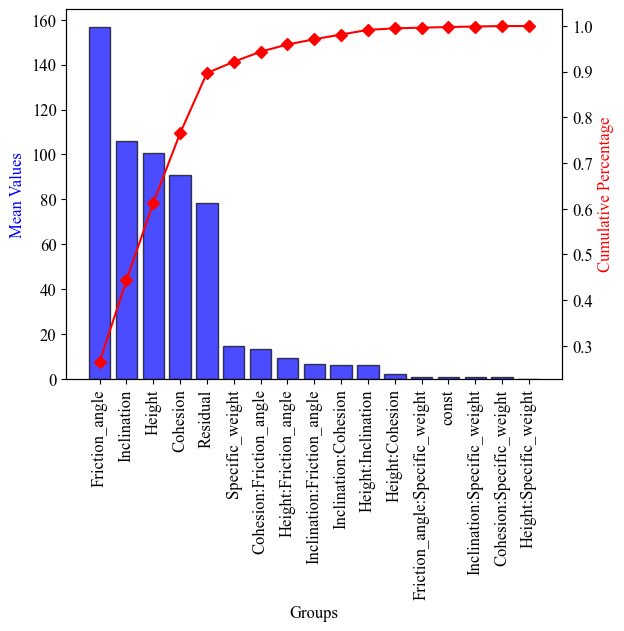

In [155]:
anova_results.sort_values(by = 'SQ (Adj)', ascending = False, inplace=True)
means = anova_results['SQ (Adj)']
groups = anova_results.index

f_statistic = ols
p_value = anova_results['P-value'][0]

# Create a Pareto chart
fig, ax1 = plt.subplots()
ax1.bar(groups, means, color='b', edgecolor = 'k', alpha=0.7)
ax2 = ax1.twinx()
ax2.plot(groups, np.cumsum(means) / np.sum(means), 'r-', marker='D')
ax1.set_xlabel('Groups')
ax1.set_xticklabels(groups, rotation=90)
ax1.set_ylabel('Mean Values', color='b')
ax2.set_ylabel('Cumulative Percentage', color='r')
# plt.title('Pareto Chart with ANOVA Results\nF-statistic: {:.2f}, p-value: {:.4f}'.format(f_statistic, p_value))
plt.show()

##### **Surface response plot**

#### **SHAP models to understand features importance**

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model's output. Each instance the given explanation is represented by a single dot on each feature fow. The x position of the dot is determined by the SHAP value (shap_values.value[instance,feature]) of that feature, and dots "pile up" along each feature row to show density. Color is used to display the original value of a feature (shap_values.data[instance,feature]).



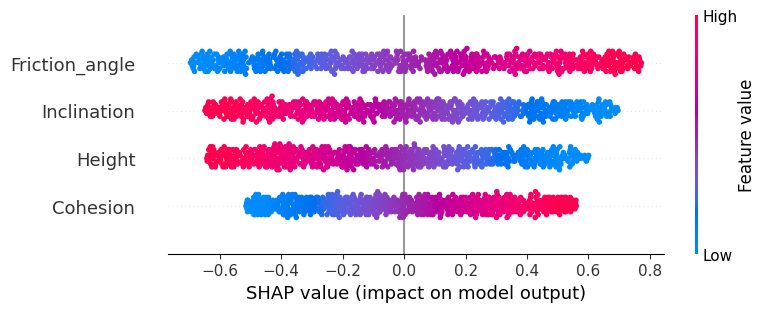

In [57]:
# !pip install shap
import shap
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
xnew = x_train.drop('Specific_weight', axis=1)


model = LinearRegression()
model = model.fit(xnew, y_train)

# Create a SHAP explainer
# explain the model's predictions using SHAP
explainer = shap.explainers.Linear(model, xnew)
shap_values = explainer(xnew)


# visualize the model's dependence on the first feature
shap.plots.beeswarm(shap_values)


##### **Global bar plot** 
Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

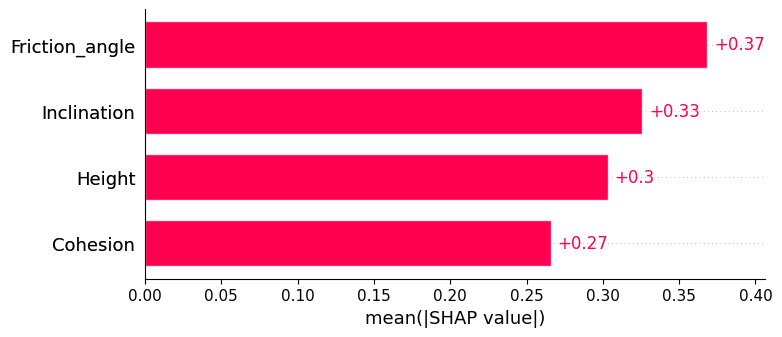

In [58]:
shap.plots.bar(shap_values)

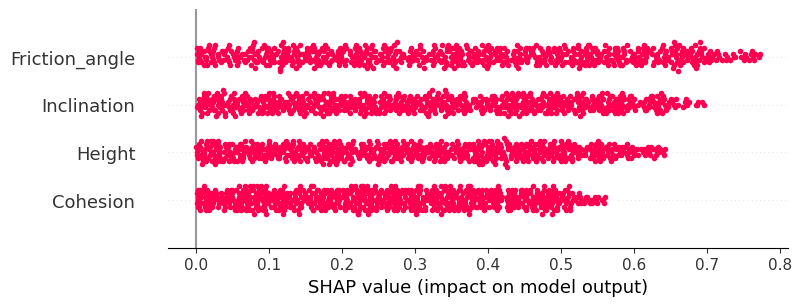

In [59]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

##### **Waterfall plots**

Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

Below is an example that plots the first explanation. Note that by default SHAP explains XGBoost classifer models in terms of their margin output, before the logistic link function. That means the units on the x-axis are log-odds units, so negative values imply probabilies of less than 0.5 that the person makes over $50k annually. The gray text before the feature names shows the value of each feature for this sample.

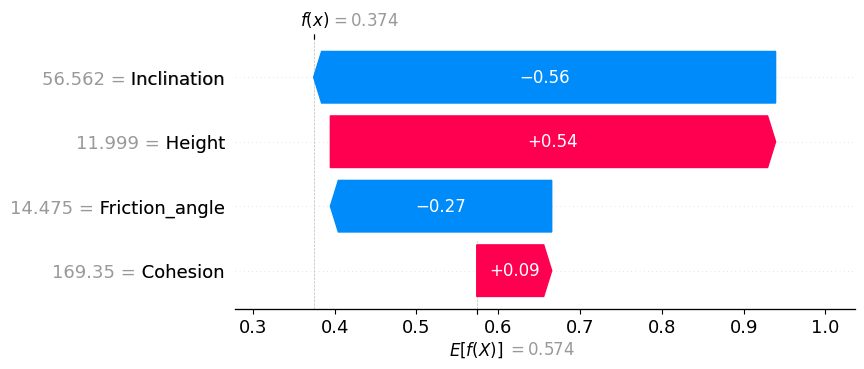

In [67]:
shap.plots.waterfall(shap_values[100])

##### **Other graph types**

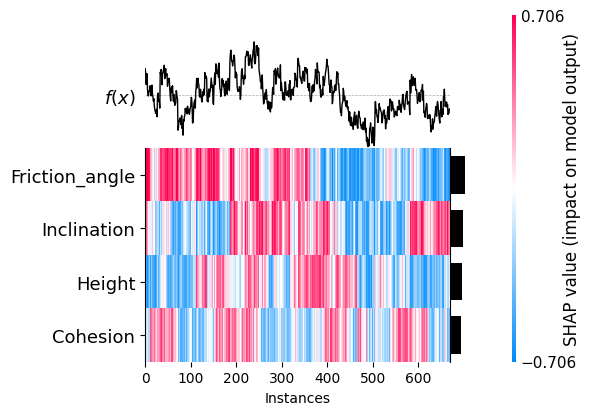

In [61]:
shap.plots.heatmap(shap_values)

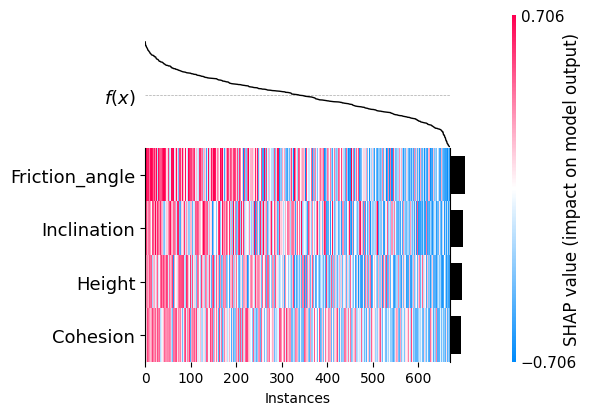

In [62]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))


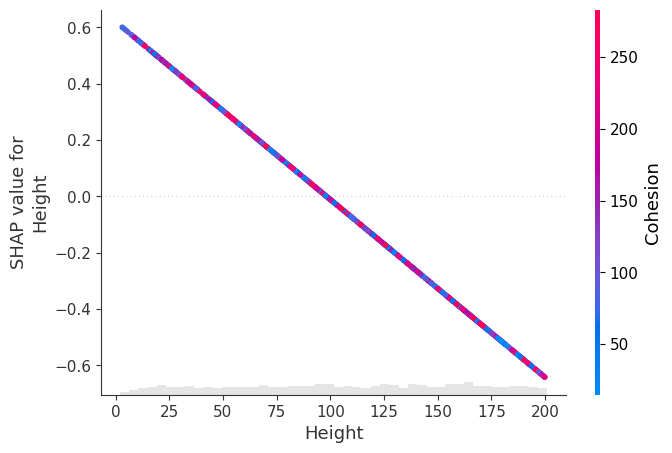

In [63]:
shap.plots.scatter(shap_values[:, "Height"], color=shap_values)

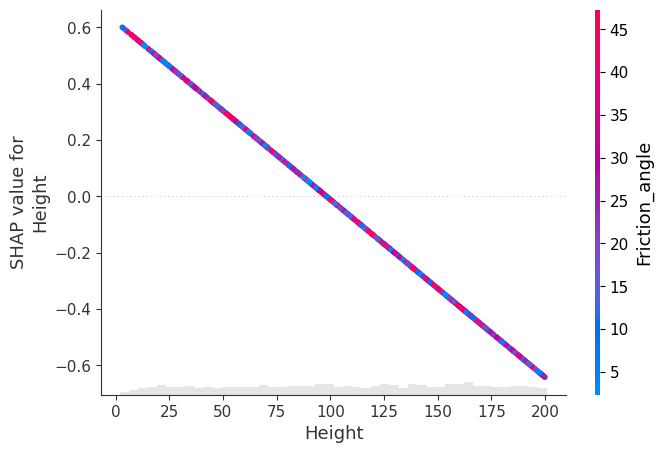

In [64]:
shap.plots.scatter(shap_values[:, "Height"], color=shap_values[:, "Friction_angle"])

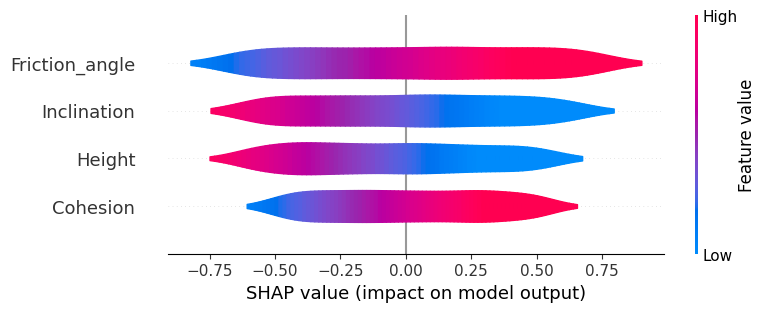

In [65]:
shap.plots.violin(shap_values)

##### **See others graph types here**

https://github.com/shap/shap/blob/master/notebooks/api_examples/plots/bar.ipynb